In [1]:
from google.colab import drive
drive.mount('/content/drive')

drive_path = '/content/drive/MyDrive/new_project1/'
final_path = '/content/drive/MyDrive/new_project1/final/data/'
final_img = '/content/drive/MyDrive/new_project1/final/img/'
final_result = '/content/drive/MyDrive/new_project1/final/result/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# # 1. 나눔 폰트 다운
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
from mpl_toolkits.axes_grid1 import make_axes_locatable

import geopandas as gpd

import statsmodels.api as sm
import re
from io import StringIO

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")



In [4]:
raw = pd.read_csv(f'{final_path}final_data.csv')
raw.head()

,ADM_CD,행정동코드,total_all,solo_all,total_20,solo_20,total_30,solo_30,total_40,solo_40,...,편의점_근접9,쇼핑_근접3,쇼핑_근접5,쇼핑_근접9,반려동물업_근접3,반려동물업_근접5,반려동물업_근접9,사업체합계2_근접3,사업체합계2_근접5,사업체합계2_근접9
0,11010530,1101053.0,8451.0,2081.0,1273.0,435.0,1535.0,480.0,1659.0,389.0,...,68.0,0.0,7.0,7.0,12.0,34.0,52.0,2297.0,12990.0,17465.0
1,11010540,1101054.0,2569.0,894.0,486.0,242.0,393.0,175.0,415.0,129.0,...,80.0,0.0,7.0,7.0,14.0,42.0,61.0,3698.0,14292.0,21026.0
2,11010550,1101055.0,9202.0,1563.0,1984.0,370.0,1330.0,320.0,1826.0,216.0,...,76.0,0.0,0.0,7.0,9.0,10.0,58.0,2703.0,4214.0,20608.0
3,11010560,1101056.0,15577.0,1633.0,2444.0,260.0,2194.0,247.0,3113.0,226.0,...,76.0,0.0,0.0,7.0,12.0,22.0,61.0,2437.0,5023.0,20342.0
4,11030740,1103074.0,19025.0,5428.0,2988.0,1198.0,4326.0,1544.0,3422.0,919.0,...,109.0,1.0,2.0,12.0,40.0,45.0,73.0,2801.0,3922.0,11388.0


In [5]:
raw['행정동명'][:20]

0       사직동
1       삼청동
2       부암동
3       평창동
4       한남동
5     왕십리2동
6       마장동
7       중림동
8       옥수동
9       장충동
10      광희동
11      사근동
12      후암동
13    용산2가동
14      남영동
15    원효로2동
16      효창동
17    이태원1동
18    금호1가동
19    금호4가동
Name: 행정동명, dtype: object

In [6]:
raw.isna().sum()

ADM_CD        0
행정동코드         0
total_all     0
solo_all      0
total_20      0
             ..
반려동물업_근접5     0
반려동물업_근접9     0
사업체합계2_근접3    0
사업체합계2_근접5    0
사업체합계2_근접9    0
Length: 583, dtype: int64

In [7]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Columns: 583 entries, ADM_CD to 사업체합계2_근접9
dtypes: float64(574), int64(2), object(7)
memory usage: 1.9+ MB


In [8]:
# 비율변수 생성

raw['solo_67'] = raw.apply(lambda x: (x['solo_60'] + x['solo_70']) / 2, axis = 1)

raw['solo_all_ratio'] = raw.apply(lambda x: x['solo_all'] / x['total_all'] * 100, axis=1)
raw['solo_20_ratio'] = raw.apply(lambda x: x['solo_20'] / x['solo_all'] * 100, axis=1)
raw['solo_30_ratio'] = raw.apply(lambda x: x['solo_30'] / x['solo_all'] * 100, axis = 1)
raw['solo_40_ratio'] = raw.apply(lambda x: x['solo_40'] / x['solo_all'] * 100, axis=1)
raw['solo_50_ratio'] = raw.apply(lambda x: x['solo_50'] / x['solo_all'] * 100, axis = 1)
raw['solo_60_ratio'] = raw.apply(lambda x: x['solo_60'] / x['solo_all'] * 100, axis = 1)
raw['solo_70_ratio'] = raw.apply(lambda x: x['solo_70'] / x['solo_all'] * 100, axis = 1)
raw['solo_67_ratio'] = raw.apply(lambda x: (x['solo_60'] + x['solo_70']) / x['solo_all'] * 100, axis = 1)

In [9]:
# 설명변수 선택
depend_list = ['행정동명', 'ADM_CD',
               'solo_all', 'solo_20', 'solo_30',  'solo_60', 'solo_70', 'solo_67',
               'solo_all_ratio', 'solo_20_ratio', 'solo_30_ratio',  'solo_60_ratio', 'solo_70_ratio', 'solo_67_ratio']

selected_var = ['금융기관_근접3', '사업체합계2', '지가 누계', '노인복지시설 개수', '안심귀갓길 개수',
                '대학교 개수_근접3', '반려동물업', '미용업', '병원', '세탁업', '약국', '영화상영관', '이용업',
                '일반음식점', '카페', '편의점', '쇼핑_근접5', '대형마트_근접3']

selected_var_name = ['금융기관', '사업체수', '지가상승률', '노인복지시설', '안심귀갓길',
                     '대학교', '반려동물업', '미용업', '병원', '세탁업', '약국', '영화상영관', '이용업',
                     '일반음식점', '카페', '편의점', '쇼핑', '대형마트']

In [10]:
df = raw[depend_list + selected_var]
df.columns = list(df.columns[:14]) + selected_var_name
df.head()

,행정동명,ADM_CD,solo_all,solo_20,solo_30,solo_60,solo_70,solo_67,solo_all_ratio,solo_20_ratio,...,병원,세탁업,약국,영화상영관,이용업,일반음식점,카페,편의점,쇼핑,대형마트
0,사직동,11010530,2081.0,435.0,480.0,219.0,302.0,260.5,24.624305,20.903412,...,2.0,8.0,14.0,4.0,10.0,1079.0,116.0,13.0,7.0,0.0
1,삼청동,11010540,894.0,242.0,175.0,91.0,128.0,109.5,34.799533,27.069351,...,0.0,1.0,3.0,0.0,0.0,263.0,58.0,1.0,7.0,0.0
2,부암동,11010550,1563.0,370.0,320.0,187.0,303.0,245.0,16.985438,23.672425,...,0.0,5.0,1.0,0.0,1.0,137.0,32.0,4.0,0.0,0.0
3,평창동,11010560,1633.0,260.0,247.0,181.0,486.0,333.5,10.483405,15.921617,...,1.0,8.0,5.0,0.0,2.0,131.0,40.0,4.0,0.0,0.0
4,한남동,11030740,5428.0,1198.0,1544.0,521.0,657.0,589.0,28.530880,22.070744,...,0.0,8.0,6.0,0.0,8.0,760.0,86.0,11.0,2.0,0.0


In [11]:
df.columns

Index(['행정동명', 'ADM_CD', 'solo_all', 'solo_20', 'solo_30', 'solo_60',
       'solo_70', 'solo_67', 'solo_all_ratio', 'solo_20_ratio',
       'solo_30_ratio', 'solo_60_ratio', 'solo_70_ratio', 'solo_67_ratio',
       '금융기관', '사업체수', '지가상승률', '노인복지시설', '안심귀갓길', '대학교', '반려동물업', '미용업', '병원',
       '세탁업', '약국', '영화상영관', '이용업', '일반음식점', '카페', '편의점', '쇼핑', '대형마트'],
      dtype='object')

# 지도 그리기 준비

In [12]:
dong_shp = gpd.read_file('/content/drive/MyDrive/new_project1/data/seoul_shp/dong/bnd_dong_11_2023_2023_2Q.shp')
dong_shp.head()

,BASE_DATE,ADM_NM,ADM_CD,geometry
0,20230701,사직동,11010530,"POLYGON ((953553.932 1953335.741, 953555.211 1..."
1,20230701,삼청동,11010540,"POLYGON ((954025.242 1953916.389, 954026.972 1..."
2,20230701,부암동,11010550,"POLYGON ((952490.380 1956548.821, 952497.594 1..."
3,20230701,평창동,11010560,"POLYGON ((953683.828 1959209.871, 953665.283 1..."
4,20230701,한남동,11030740,"POLYGON ((956238.296 1950166.610, 956237.942 1..."


In [13]:
df['ADM_CD'] = df['ADM_CD'].astype('int')
dong_shp['ADM_CD'] = dong_shp['ADM_CD'].astype('int')

map_base = dong_shp.merge(df,
                          how = 'left',
                          on = 'ADM_CD')
map_base.head()

,BASE_DATE,ADM_NM,ADM_CD,geometry,행정동명,solo_all,solo_20,solo_30,solo_60,solo_70,...,병원,세탁업,약국,영화상영관,이용업,일반음식점,카페,편의점,쇼핑,대형마트
0,20230701,사직동,11010530,"POLYGON ((953553.932 1953335.741, 953555.211 1...",사직동,2081.0,435.0,480.0,219.0,302.0,...,2.0,8.0,14.0,4.0,10.0,1079.0,116.0,13.0,7.0,0.0
1,20230701,삼청동,11010540,"POLYGON ((954025.242 1953916.389, 954026.972 1...",삼청동,894.0,242.0,175.0,91.0,128.0,...,0.0,1.0,3.0,0.0,0.0,263.0,58.0,1.0,7.0,0.0
2,20230701,부암동,11010550,"POLYGON ((952490.380 1956548.821, 952497.594 1...",부암동,1563.0,370.0,320.0,187.0,303.0,...,0.0,5.0,1.0,0.0,1.0,137.0,32.0,4.0,0.0,0.0
3,20230701,평창동,11010560,"POLYGON ((953683.828 1959209.871, 953665.283 1...",평창동,1633.0,260.0,247.0,181.0,486.0,...,1.0,8.0,5.0,0.0,2.0,131.0,40.0,4.0,0.0,0.0
4,20230701,한남동,11030740,"POLYGON ((956238.296 1950166.610, 956237.942 1...",한남동,5428.0,1198.0,1544.0,521.0,657.0,...,0.0,8.0,6.0,0.0,8.0,760.0,86.0,11.0,2.0,0.0


In [14]:
raw['ADM_CD'] = raw['ADM_CD'].astype('int')
dong_shp['ADM_CD'] = dong_shp['ADM_CD'].astype('int')

map_base2 = dong_shp.merge(raw,
                          how = 'left',
                          on = 'ADM_CD')
map_base2.head()

,BASE_DATE,ADM_NM,ADM_CD,geometry,행정동코드,total_all,solo_all,total_20,solo_20,total_30,...,사업체합계2_근접9,solo_67,solo_all_ratio,solo_20_ratio,solo_30_ratio,solo_40_ratio,solo_50_ratio,solo_60_ratio,solo_70_ratio,solo_67_ratio
0,20230701,사직동,11010530,"POLYGON ((953553.932 1953335.741, 953555.211 1...",1101053.0,8451.0,2081.0,1273.0,435.0,1535.0,...,17465.0,260.5,24.624305,20.903412,23.065834,18.692936,12.301778,10.523787,14.512254,25.036040
1,20230701,삼청동,11010540,"POLYGON ((954025.242 1953916.389, 954026.972 1...",1101054.0,2569.0,894.0,486.0,242.0,393.0,...,21026.0,109.5,34.799533,27.069351,19.574944,14.429530,14.429530,10.178971,14.317673,24.496644
2,20230701,부암동,11010550,"POLYGON ((952490.380 1956548.821, 952497.594 1...",1101055.0,9202.0,1563.0,1984.0,370.0,1330.0,...,20608.0,245.0,16.985438,23.672425,20.473448,13.819578,10.684581,11.964171,19.385797,31.349968
3,20230701,평창동,11010560,"POLYGON ((953683.828 1959209.871, 953665.283 1...",1101056.0,15577.0,1633.0,2444.0,260.0,2194.0,...,20342.0,333.5,10.483405,15.921617,15.125536,13.839559,14.268218,11.083895,29.761176,40.845070
4,20230701,한남동,11030740,"POLYGON ((956238.296 1950166.610, 956237.942 1...",1103074.0,19025.0,5428.0,2988.0,1198.0,4326.0,...,11388.0,589.0,28.530880,22.070744,28.445099,16.930730,10.851142,9.598379,12.103906,21.702284


# 인구분포 지도

In [15]:
cnt_list = ['solo_all', 'solo_20', 'solo_30', 'solo_67']
ratio_list = ['solo_all_ratio', 'solo_20_ratio', 'solo_30_ratio', 'solo_67_ratio']
ratio_colname = ['전체 1인가구', '20대 1인 가구', '30대 1인 가구', '60/70대 1인 가구']
cmap_list = ['Oranges', 'Blues', 'Greens', 'Reds']
color_list = ['Orange', 'Blue', 'Green', 'Red']

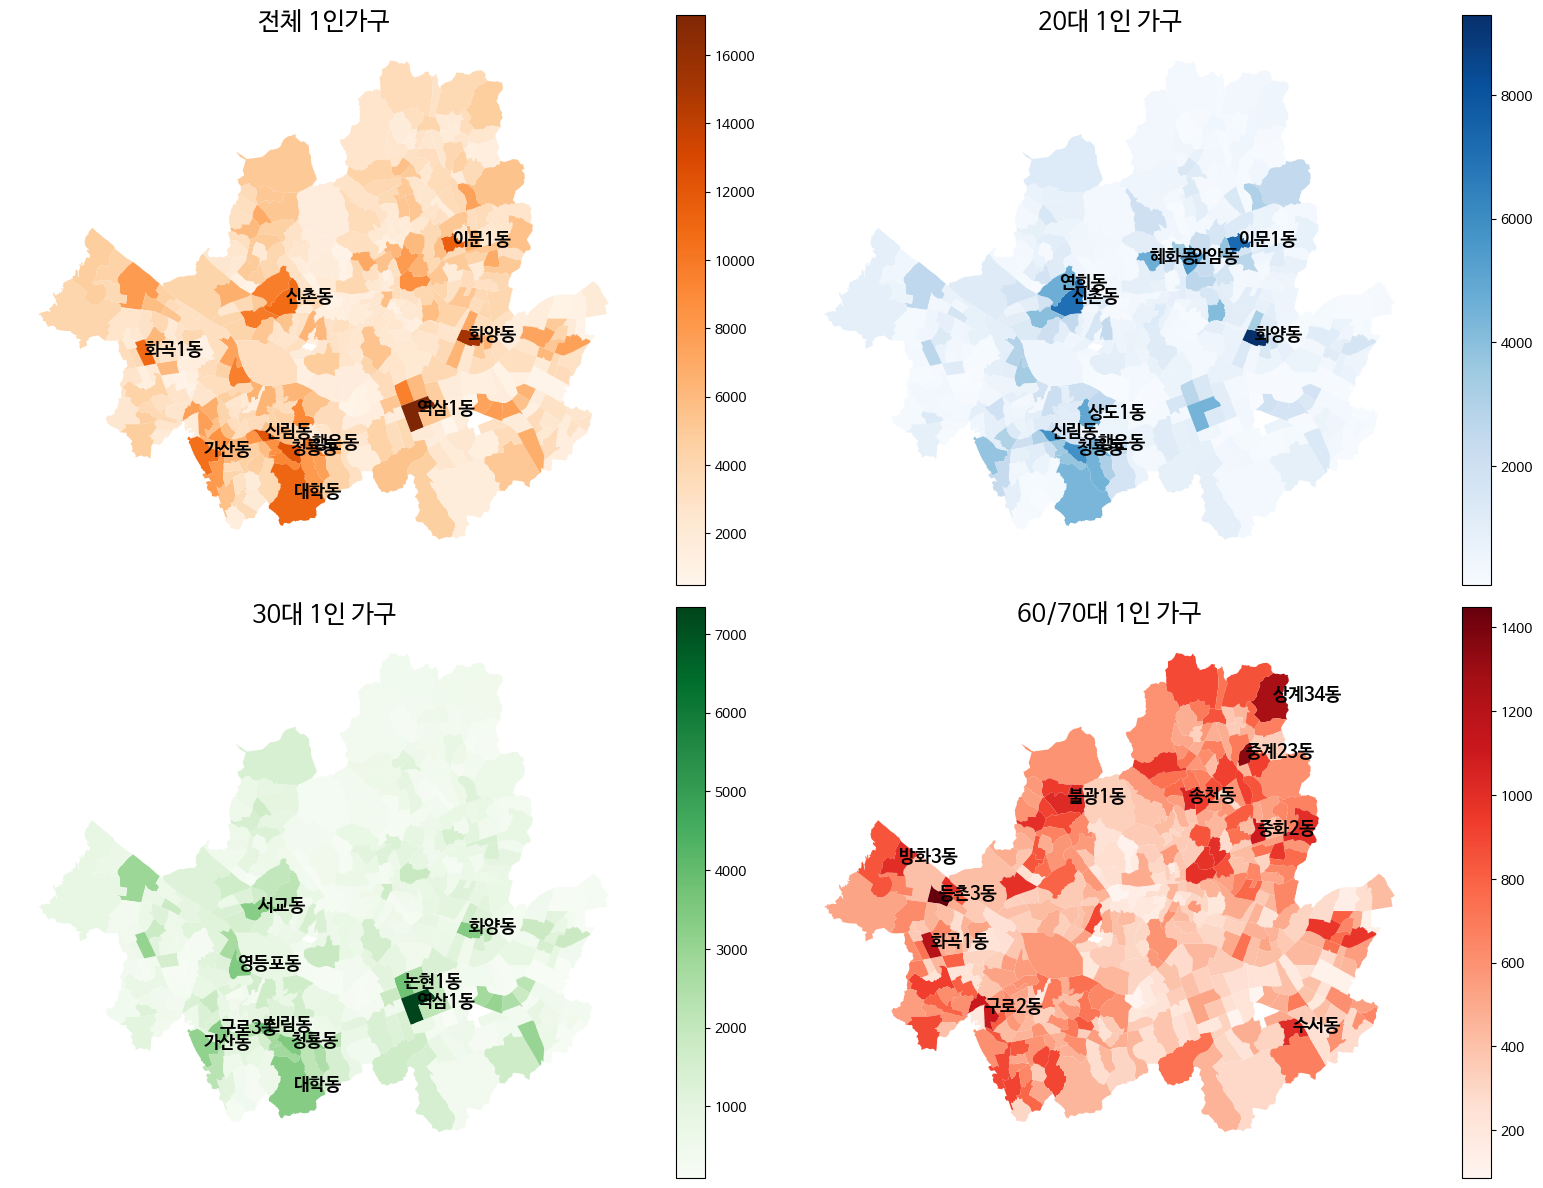

In [16]:
# 1인가구 수 그래프 그리기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for i, ratio in enumerate(cnt_list):
    row = i // 2
    col = i % 2

    # 그래프 그리기
    map_base.plot(column=ratio, ax=axes[row, col], legend=True, cmap=cmap_list[i])
    axes[row, col].set_title(ratio_colname[i] , fontsize=18)
    axes[row, col].axis('off')

    # 상위 10개 지역 표시
    top_10 = map_base.nlargest(10, ratio)
    for idx in range(len(top_10)):
        lat = top_10.geometry.centroid.x.iloc[idx]
        long = top_10.geometry.centroid.y.iloc[idx]
        axes[row, col].text(lat, long, top_10["행정동명"].iloc[idx], fontsize=13, color='black', fontweight='bold')

plt.tight_layout()

# 이미지 저장
plt.savefig(f'{final_img}1인 가구 수.png', format='png')
plt.show()

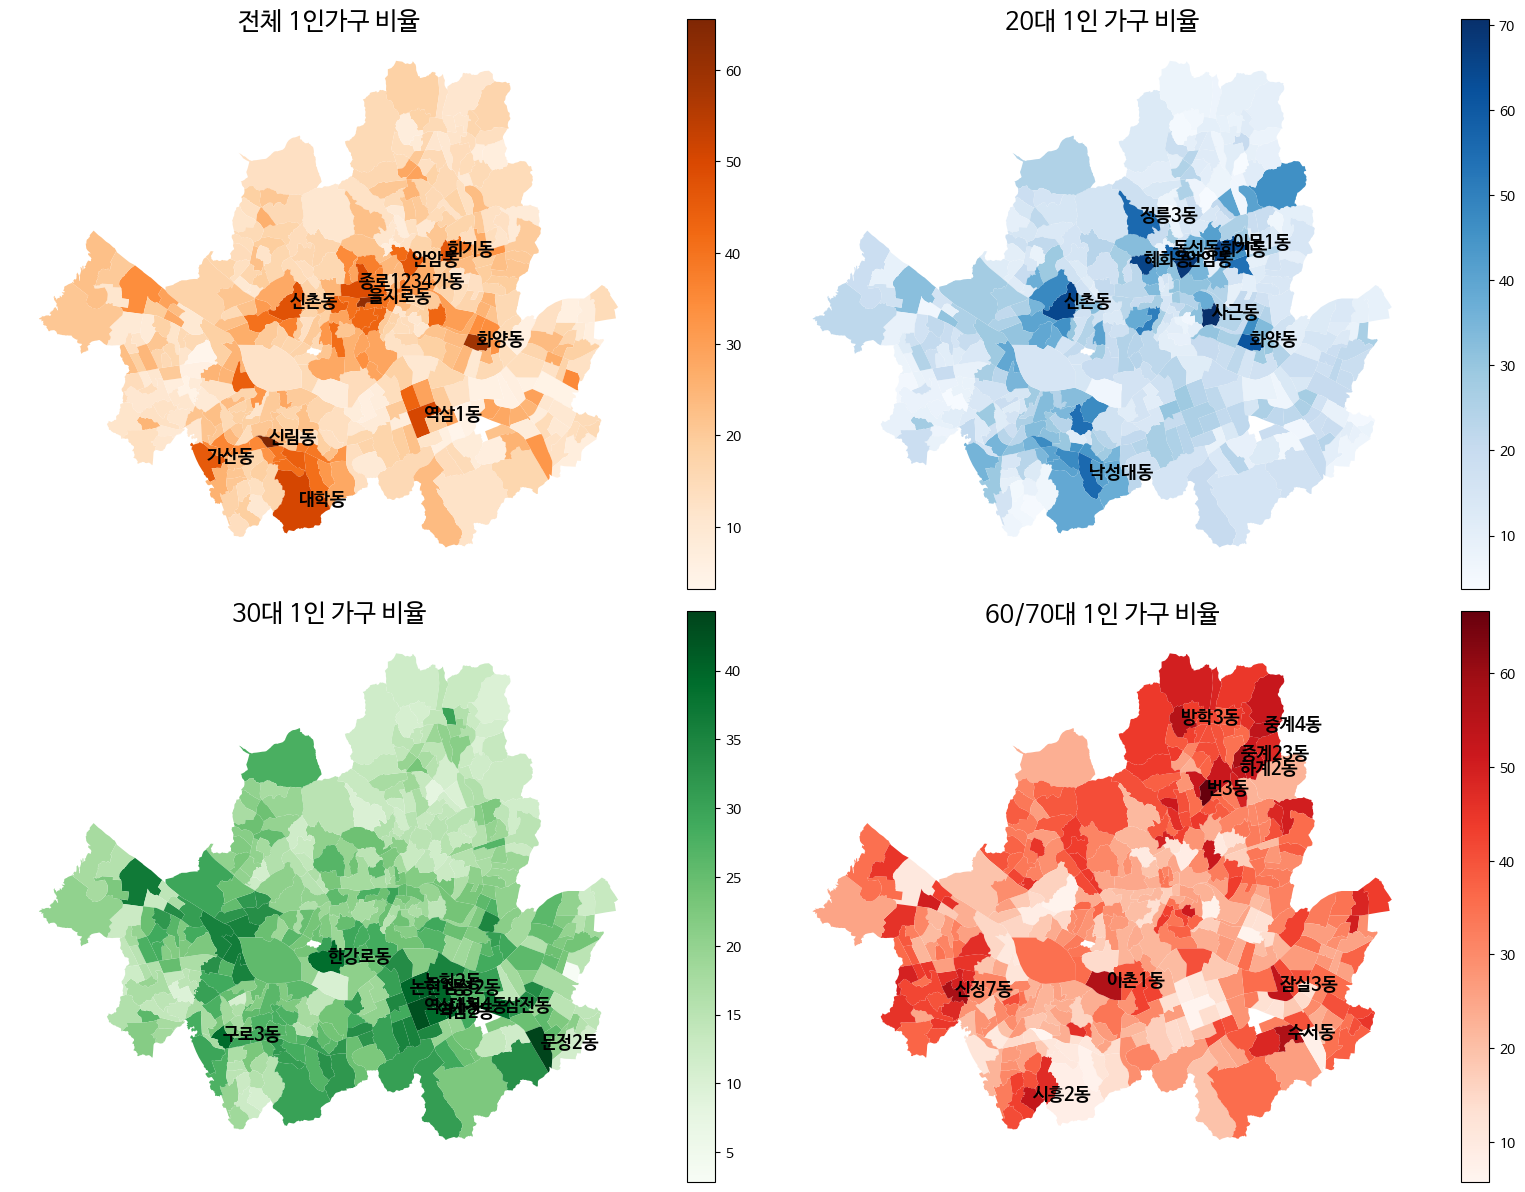

In [17]:
# 1인가구 비율 그래프 그리기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for i, ratio in enumerate(ratio_list):
    row = i // 2
    col = i % 2

    # 그래프 그리기
    map_base.plot(column=ratio, ax=axes[row, col], legend=True, cmap=cmap_list[i])
    axes[row, col].set_title(ratio_colname[i] + " 비율", fontsize=18)
    axes[row, col].axis('off')

    # 상위 10개 지역 표시
    top_10 = map_base.nlargest(10, ratio)
    for idx in range(len(top_10)):
        lat = top_10.geometry.centroid.x.iloc[idx]
        long = top_10.geometry.centroid.y.iloc[idx]
        axes[row, col].text(lat, long, top_10["행정동명"].iloc[idx], fontsize=13, color='black', fontweight='bold')

plt.tight_layout()

# 이미지 저장
plt.savefig(f'{final_img}1인 가구 비율.png', format='png')
plt.show()

In [18]:
# 지역특성 그래프 그리기

len(selected_var)


18

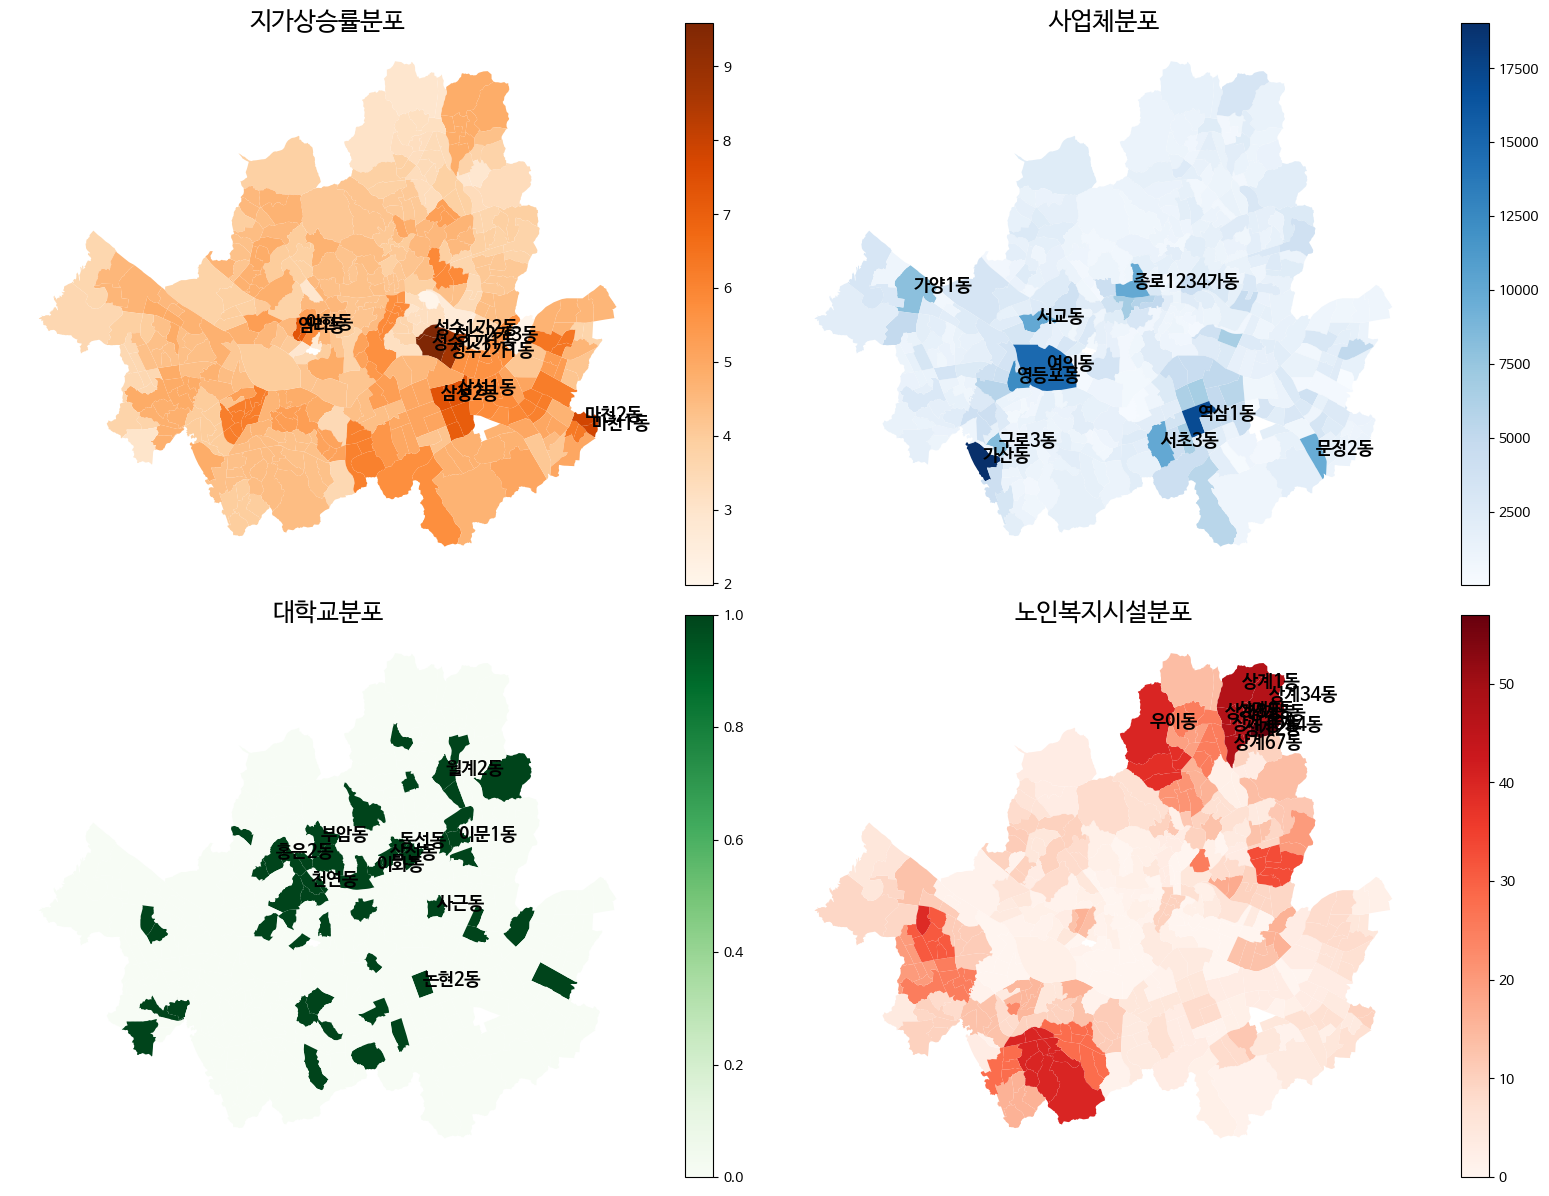

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

map_var = ['지가 누계', '사업체합계2', '대학교 개수', '노인복지시설 개수']
var_name2 = ['지가상승률', '사업체', '대학교', '노인복지시설']


for i, var in enumerate(map_var):
    row = i // 2
    col = i % 2

    # 그래프 그리기
    map_base2.plot(column= var, ax=axes[row, col], legend=True, cmap=cmap_list[i])
    axes[row, col].set_title(var_name2[i] + "분포", fontsize=18)
    axes[row, col].axis('off')

    # 상위 10개 지역 표시
    top_10 = map_base2.nlargest(10, var)
    for idx in range(len(top_10)):
        lat = top_10.geometry.centroid.x.iloc[idx]
        long = top_10.geometry.centroid.y.iloc[idx]
        axes[row, col].text(lat, long, top_10["행정동명"].iloc[idx], fontsize=13, color='black', fontweight='bold')

plt.tight_layout()

# 이미지 저장
plt.savefig(f'{final_img}지역특성지도.png', format='png')
plt.show()

In [20]:
# # 지역특성 상위 10개동

# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# map_var = ['지가상승률', '사업체수', '편의점', '노인복지시설']


# for i, var in enumerate(map_var):
#     row = i // 2
#     col = i % 2
#     data = map_base.nlargest(10, var)


#     axes[row, col].bar(data['행정동명'], data['solo_all_ratio'], color=color_list[i])
#     axes[row, col].bar(data['행정동명'], data['solo_20_ratio'], color=color_list[i])
#     axes[row, col].bar(data['행정동명'], data['solo_30_ratio'], color=color_list[i])
#     axes[row, col].bar(data['행정동명'], data['solo_67_ratio'], color=color_list[i])
#     axes[row, col].set_title(f"{var} 분포", fontsize=18)
#     axes[row, col].set_ylabel("분포")

# # plt.suptitle('1인가구 비율', fontsize=20)
# plt.tight_layout()

# # 이미지 저장
# plt.savefig('/content/drive/MyDrive/new_project1/final_img/지역 특성.png', format='png')
# plt.show()

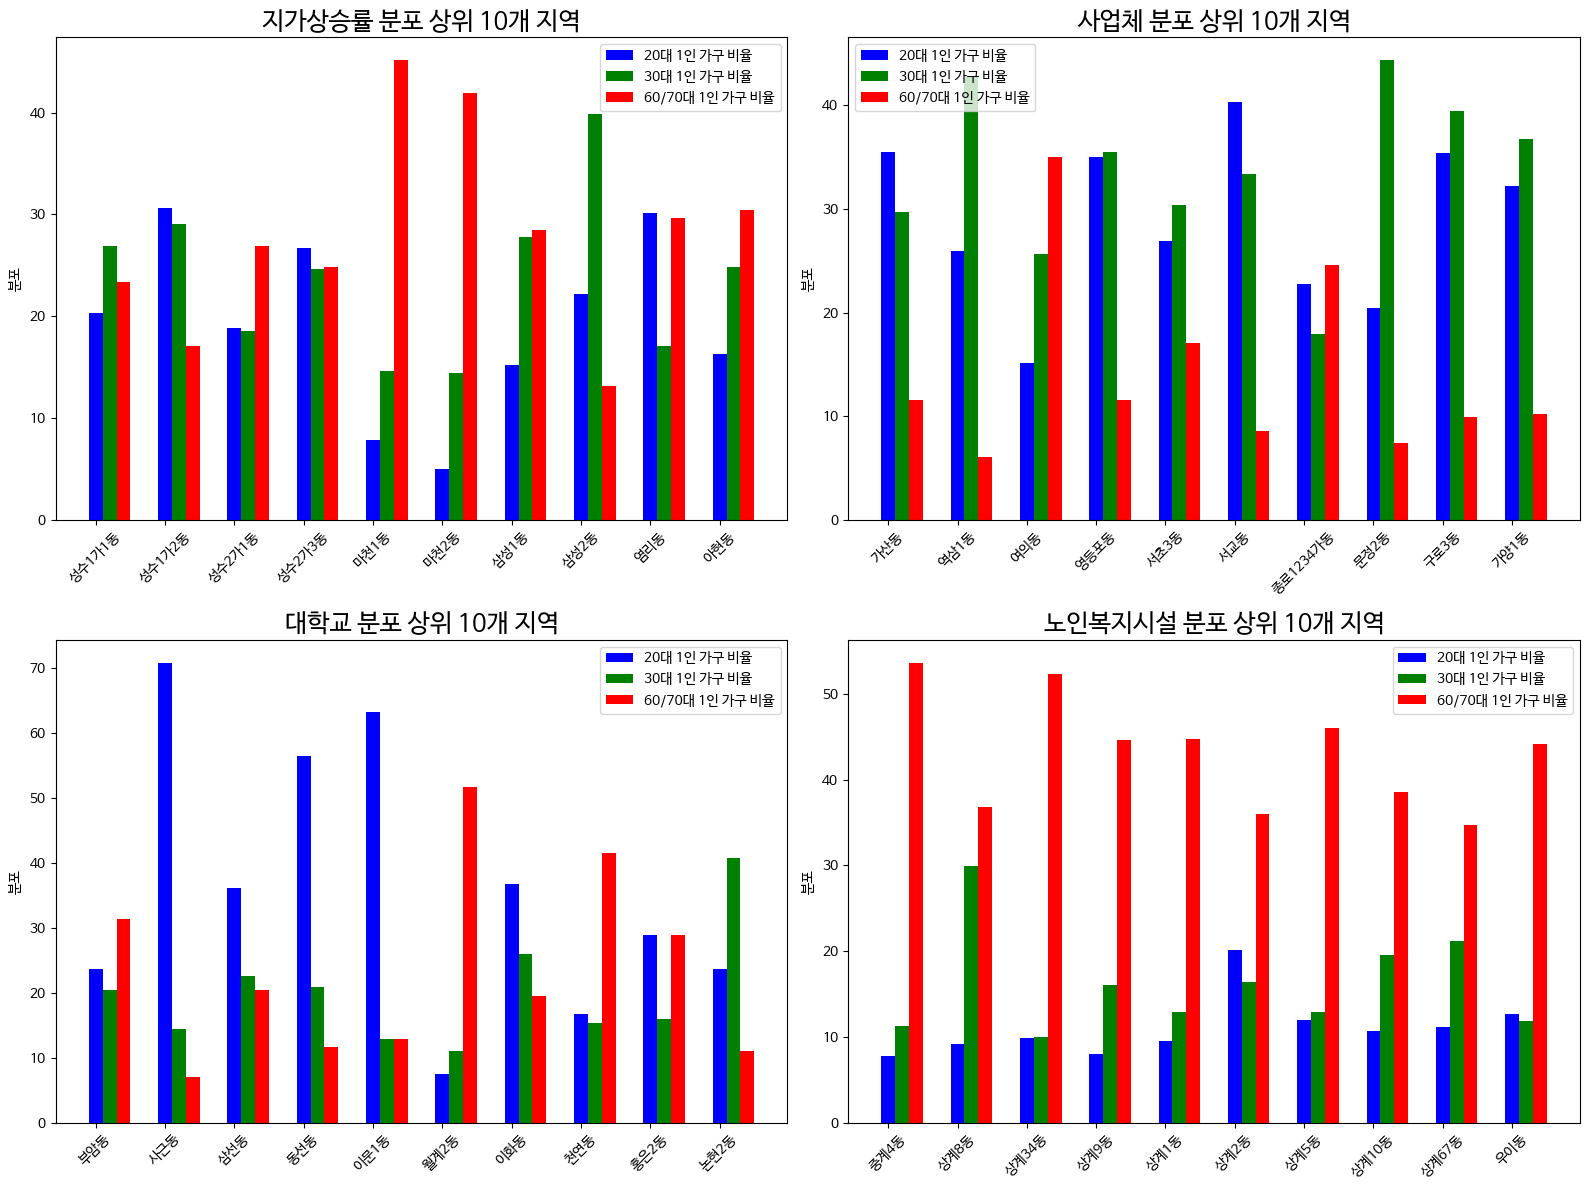

In [21]:
# 1지역특성 상위 10개동 그래프
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

map_var = ['지가 누계', '사업체합계2', '대학교 개수', '노인복지시설 개수']
var_name2 = ['지가상승률', '사업체', '대학교', '노인복지시설']

for i, var in enumerate(map_var):
    row = i // 2
    col = i % 2
    data = map_base2.nlargest(10, var)

    bar_width = 0.2
    index = np.arange(len(data['행정동명']))

    # axes[row, col].bar(index - bar_width, data['solo_all_ratio'], width=bar_width, color=color_list[0], label='전체 1인가구 비율')
    axes[row, col].bar(index, data['solo_20_ratio'], width=bar_width, color=color_list[1], label='20대 1인 가구 비율')
    axes[row, col].bar(index + bar_width, data['solo_30_ratio'], width=bar_width, color=color_list[2], label='30대 1인 가구 비율')
    axes[row, col].bar(index + 2*bar_width, data['solo_67_ratio'], width=bar_width, color=color_list[3], label='60/70대 1인 가구 비율')

    axes[row, col].set_title(f"{var_name2[i]} 분포 상위 10개 지역", fontsize=18)
    axes[row, col].set_ylabel("분포")
    axes[row, col].set_xticks(index)
    axes[row, col].set_xticklabels(data['행정동명'], rotation=45)
    axes[row, col].legend()

# plt.suptitle('1인가구 비율', fontsize=20)
plt.tight_layout()
plt.savefig(f'{final_img}지역 특성.png', format='png')
plt.show()

In [22]:
df

,행정동명,ADM_CD,solo_all,solo_20,solo_30,solo_60,solo_70,solo_67,solo_all_ratio,solo_20_ratio,...,병원,세탁업,약국,영화상영관,이용업,일반음식점,카페,편의점,쇼핑,대형마트
0,사직동,11010530,2081.0,435.0,480.0,219.0,302.0,260.5,24.624305,20.903412,...,2.0,8.0,14.0,4.0,10.0,1079.0,116.0,13.0,7.0,0.0
1,삼청동,11010540,894.0,242.0,175.0,91.0,128.0,109.5,34.799533,27.069351,...,0.0,1.0,3.0,0.0,0.0,263.0,58.0,1.0,7.0,0.0
2,부암동,11010550,1563.0,370.0,320.0,187.0,303.0,245.0,16.985438,23.672425,...,0.0,5.0,1.0,0.0,1.0,137.0,32.0,4.0,0.0,0.0
3,평창동,11010560,1633.0,260.0,247.0,181.0,486.0,333.5,10.483405,15.921617,...,1.0,8.0,5.0,0.0,2.0,131.0,40.0,4.0,0.0,0.0
4,한남동,11030740,5428.0,1198.0,1544.0,521.0,657.0,589.0,28.530880,22.070744,...,0.0,8.0,6.0,0.0,8.0,760.0,86.0,11.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,가회동,11010600,1157.0,204.0,278.0,145.0,189.0,167.0,28.752485,17.631806,...,0.0,2.0,2.0,0.0,2.0,199.0,53.0,4.0,7.0,0.0
416,종로1234가동,11010610,4033.0,916.0,722.0,566.0,425.0,495.5,48.979840,22.712621,...,0.0,14.0,55.0,8.0,36.0,2436.0,229.0,30.0,3.0,0.0
417,방배2동,11220630,3099.0,692.0,757.0,409.0,497.0,453.0,13.799092,22.329784,...,8.0,40.0,45.0,0.0,21.0,1156.0,230.0,70.0,2.0,0.0
418,미아동,11090700,5068.0,1298.0,955.0,656.0,770.0,713.0,25.317215,25.611681,...,8.0,59.0,62.0,6.0,41.0,1341.0,110.0,58.0,4.0,1.0


In [23]:
## 1인가구 상위 지역

In [24]:
top_result = pd.DataFrame()
top10_result = pd.DataFrame()

for depend in ratio_list:
    temp = df.nlargest(10, depend)
    temp_sum = temp[selected_var_name].sum()
    temp_dong =pd.DataFrame(temp_sum)
    temp_dong.columns = [depend]

    if depend == 'solo_all_ratio':
        top_result = temp_dong
    else:
        top_result = pd.concat([top_result, temp_dong], axis = 1)

    globals()[f'top10_{depend}']= temp

    temp_sum = temp[selected_var_name].mean()

    temp_sum =pd.DataFrame(temp_sum)
    temp_sum.columns = [depend]

    if depend == 'solo_all_ratio':
        top10_result = temp_sum
    else:
        top10_result = pd.concat([top10_result, temp_sum], axis = 1)

top10_result.columns = ratio_colname

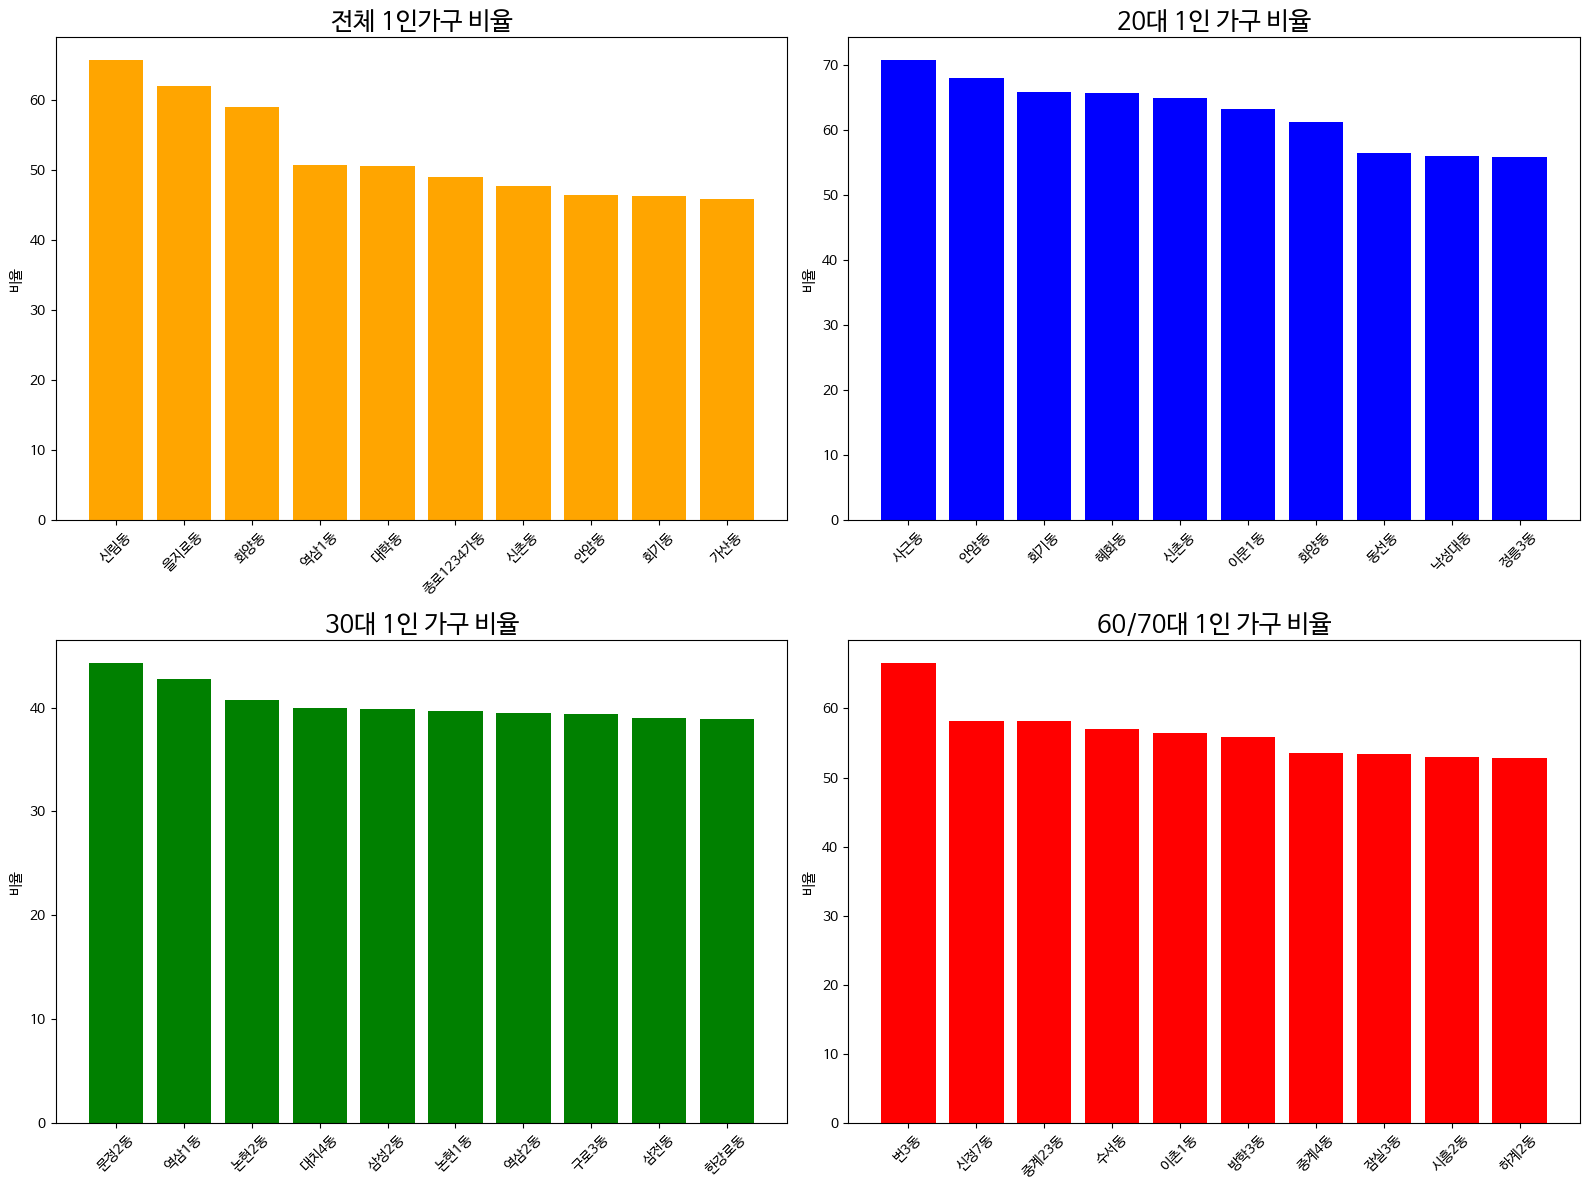

In [25]:
# 1인가구 비율 상위 10개동

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

for i, (ratio, title) in enumerate(zip(ratio_list, ratio_colname)):
    row = i // 2
    col = i % 2

    data = globals()[f'top10_{ratio}']

    # 그래프 그리기
    axes[row, col].bar(data['행정동명'], data[f'{ratio}'], color=color_list[i])
    axes[row, col].set_title(f"{title} 비율", fontsize=18)
    axes[row, col].set_ylabel("비율")
    axes[row, col].set_xticklabels(data['행정동명'], rotation=45)

# plt.suptitle('1인가구 비율', fontsize=20)
plt.tight_layout()

# 이미지 저장
plt.savefig(f'{final_img}1인 가구 동.png', format='png')
plt.show()

In [26]:
top10_result

,전체 1인가구,20대 1인 가구,30대 1인 가구,60/70대 1인 가구
금융기관,18.0000,8.4000,39.6000,9.000
사업체수,6433.5000,1762.5000,6784.4000,1098.700
지가상승률,4.2417,3.9818,5.3299,4.116
노인복지시설,9.5000,4.9000,5.0000,15.600
안심귀갓길,2.3000,0.7000,0.3000,0.000
대학교,0.7000,0.7000,0.2000,0.300
반려동물업,35.5000,19.9000,59.7000,43.800
미용업,263.6000,183.3000,368.0000,270.200
병원,2.7000,1.8000,5.7000,3.000
세탁업,34.1000,19.3000,40.2000,31.200


In [27]:
top10_result.index = selected_var_name

In [28]:
top10_result.head()

,전체 1인가구,20대 1인 가구,30대 1인 가구,60/70대 1인 가구
금융기관,18.0000,8.4000,39.6000,9.000
사업체수,6433.5000,1762.5000,6784.4000,1098.700
지가상승률,4.2417,3.9818,5.3299,4.116
노인복지시설,9.5000,4.9000,5.0000,15.600
안심귀갓길,2.3000,0.7000,0.3000,0.000


In [29]:
top10_result.to_excel(f'{final_result}top10.xlsx')

In [30]:
top10_result.to_csv(f'{final_result}top10.csv')

In [31]:
ratio

'solo_67_ratio'

In [32]:
### 변수간의 상관관계

In [33]:
df.columns[8:]

Index(['solo_all_ratio', 'solo_20_ratio', 'solo_30_ratio', 'solo_60_ratio',
       'solo_70_ratio', 'solo_67_ratio', '금융기관', '사업체수', '지가상승률', '노인복지시설',
       '안심귀갓길', '대학교', '반려동물업', '미용업', '병원', '세탁업', '약국', '영화상영관', '이용업',
       '일반음식점', '카페', '편의점', '쇼핑', '대형마트'],
      dtype='object')

In [34]:
df_selected = df.iloc[: , 8:]
df_selected.head()

,solo_all_ratio,solo_20_ratio,solo_30_ratio,solo_60_ratio,solo_70_ratio,solo_67_ratio,금융기관,사업체수,지가상승률,노인복지시설,...,병원,세탁업,약국,영화상영관,이용업,일반음식점,카페,편의점,쇼핑,대형마트
0,24.624305,20.903412,23.065834,10.523787,14.512254,25.036040,5.0,4213.0,4.353,1,...,2.0,8.0,14.0,4.0,10.0,1079.0,116.0,13.0,7.0,0.0
1,34.799533,27.069351,19.574944,10.178971,14.317673,24.496644,11.0,652.0,4.253,0,...,0.0,1.0,3.0,0.0,0.0,263.0,58.0,1.0,7.0,0.0
2,16.985438,23.672425,20.473448,11.964171,19.385797,31.349968,7.0,673.0,4.741,2,...,0.0,5.0,1.0,0.0,1.0,137.0,32.0,4.0,0.0,0.0
3,10.483405,15.921617,15.125536,11.083895,29.761176,40.845070,6.0,939.0,4.131,8,...,1.0,8.0,5.0,0.0,2.0,131.0,40.0,4.0,0.0,0.0
4,28.530880,22.070744,28.445099,9.598379,12.103906,21.702284,9.0,2380.0,5.706,4,...,0.0,8.0,6.0,0.0,8.0,760.0,86.0,11.0,2.0,0.0


In [35]:
df_selected.columns = list(df_selected.columns[:6]) + selected_var_name
df_selected.head()

,solo_all_ratio,solo_20_ratio,solo_30_ratio,solo_60_ratio,solo_70_ratio,solo_67_ratio,금융기관,사업체수,지가상승률,노인복지시설,...,병원,세탁업,약국,영화상영관,이용업,일반음식점,카페,편의점,쇼핑,대형마트
0,24.624305,20.903412,23.065834,10.523787,14.512254,25.036040,5.0,4213.0,4.353,1,...,2.0,8.0,14.0,4.0,10.0,1079.0,116.0,13.0,7.0,0.0
1,34.799533,27.069351,19.574944,10.178971,14.317673,24.496644,11.0,652.0,4.253,0,...,0.0,1.0,3.0,0.0,0.0,263.0,58.0,1.0,7.0,0.0
2,16.985438,23.672425,20.473448,11.964171,19.385797,31.349968,7.0,673.0,4.741,2,...,0.0,5.0,1.0,0.0,1.0,137.0,32.0,4.0,0.0,0.0
3,10.483405,15.921617,15.125536,11.083895,29.761176,40.845070,6.0,939.0,4.131,8,...,1.0,8.0,5.0,0.0,2.0,131.0,40.0,4.0,0.0,0.0
4,28.530880,22.070744,28.445099,9.598379,12.103906,21.702284,9.0,2380.0,5.706,4,...,0.0,8.0,6.0,0.0,8.0,760.0,86.0,11.0,2.0,0.0


In [36]:
df_corr = df_selected.corr(numeric_only = True)

In [37]:
df_corr.head()

,solo_all_ratio,solo_20_ratio,solo_30_ratio,solo_60_ratio,solo_70_ratio,solo_67_ratio,금융기관,사업체수,지가상승률,노인복지시설,...,병원,세탁업,약국,영화상영관,이용업,일반음식점,카페,편의점,쇼핑,대형마트
solo_all_ratio,1.000000,0.661663,0.342370,-0.508751,-0.725342,-0.694455,0.114242,0.342638,-0.034627,-0.039701,...,-0.006641,0.042361,0.017532,0.128236,0.006442,0.184199,0.154420,0.129397,0.212337,-0.096893
solo_20_ratio,0.661663,1.000000,0.314658,-0.793378,-0.708183,-0.788892,0.027325,0.174441,-0.006151,-0.140494,...,-0.053042,-0.014251,0.006686,0.041078,-0.099368,0.076683,0.107816,0.056642,0.068365,-0.120098
solo_30_ratio,0.342370,0.314658,1.000000,-0.726140,-0.670963,-0.737886,0.331199,0.439819,0.239122,-0.163704,...,0.166328,0.133867,0.191262,0.235815,-0.031541,0.311686,0.345343,0.240029,0.195411,-0.003881
solo_60_ratio,-0.508751,-0.793378,-0.726140,1.000000,0.725253,0.877978,-0.214236,-0.348502,-0.139905,0.203635,...,-0.033262,-0.032015,-0.100718,-0.172320,0.122600,-0.200136,-0.255599,-0.135994,-0.156624,0.048221
solo_70_ratio,-0.725342,-0.708183,-0.670963,0.725253,1.000000,0.966334,-0.190433,-0.349225,-0.146193,0.121175,...,-0.068368,-0.095064,-0.091064,-0.125301,-0.003048,-0.240161,-0.238943,-0.193517,-0.141707,0.094722


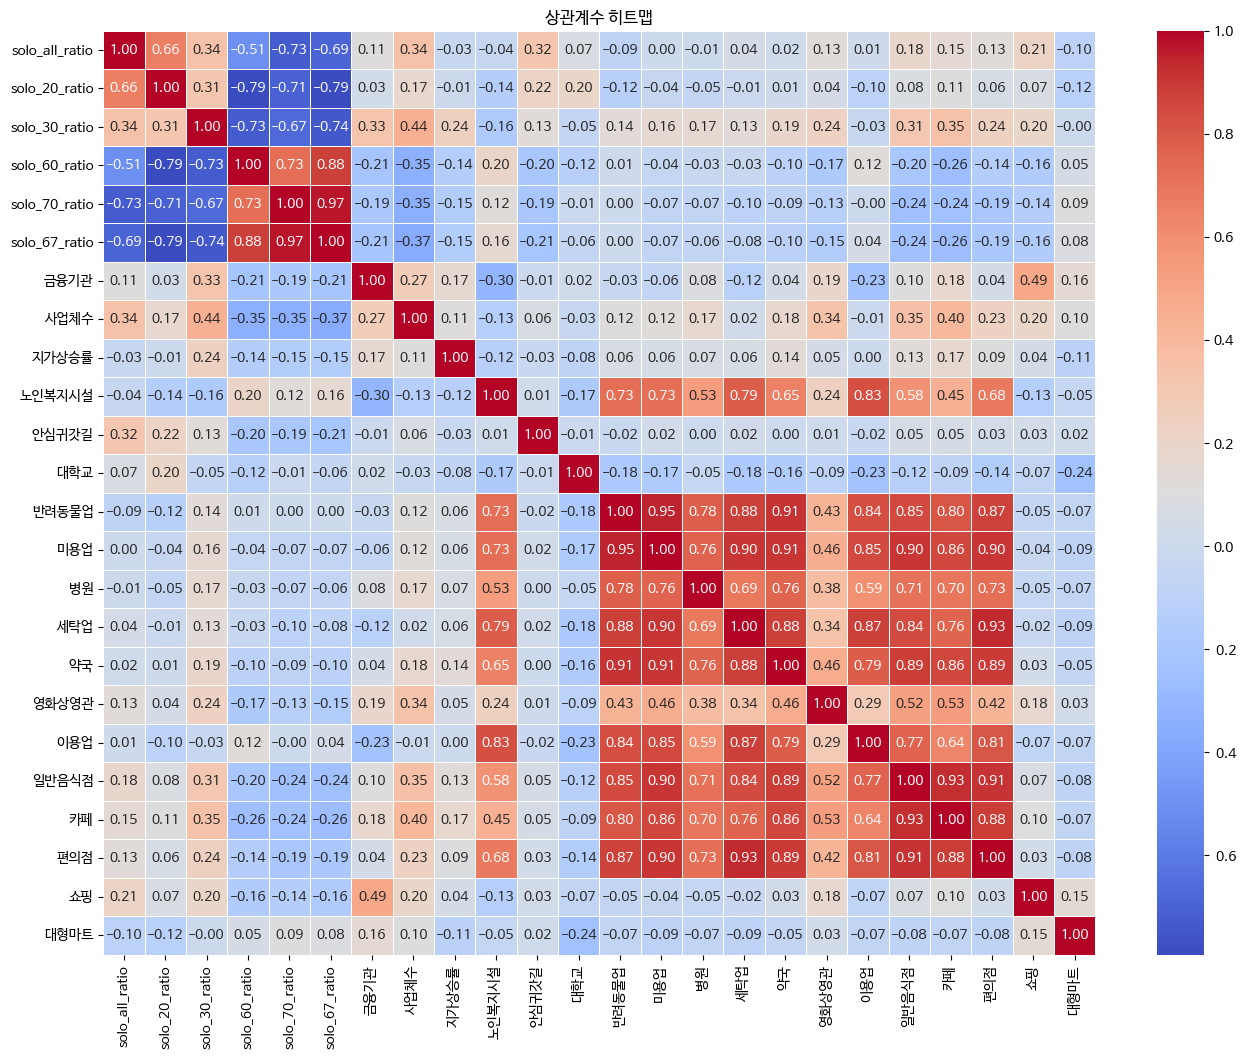

In [38]:
import seaborn as sns

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("상관계수 히트맵")
plt.savefig(f'{final_img}상관관계.png', format='png')
plt.show()